In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
from keras.constraints import NonNeg
import innvestigate
from sklearn.model_selection import train_test_split

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

Running on GPU


2024-04-21 22:10:53.299639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 22:10:56.655944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:10:56.658532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:10:56.660835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize_new(field, num_years = 31, first_leap_year_idx = 0):
    
    leap_yr_offsets_jan_feb   = np.array([0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8])
    leap_yr_offsets_after_feb = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8])

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        same_cal_days_idx=[d+365*year+leap_yr_offsets_jan_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    same_cal_days_idx=[365*year+59+int(year/4) for year in range(first_leap_year_idx,num_years,4)]
    # Remove mean
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='constant', 
                                                    overwrite_data=False)
    # Remove linear trend
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='linear', 
                                                    overwrite_data=False)
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        same_cal_days_idx=[d-1+365*year+leap_yr_offsets_after_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize_new(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize_new(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; Mean removed and delinearized for each calendar day."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; Mean removed and delinearized for each calendar day."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; Mean removed and delinearized for each calendar day."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Classification

In [8]:
def LRP(model, model_wo_softmax, X, y_true, lagSteps, lrp_methods, 
        suffix, normalizeDict, **kwargs):

    result = {}
    cost_NN = model.predict(X)
    result[f'score_{suffix}'] = model.evaluate(X, y_true, verbose=0)

    pred_NN = cost_NN.copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] > 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(y_true[lagSteps:,0])):
            if y_true[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if y_true[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                idx_NN_neg.append(i)
    else:
        for i in range(len(y_true[:lagSteps,0])):
            if y_true[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i-lagSteps)
            if y_true[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                idx_NN_neg.append(i-lagSteps)

    result[f'idx_NN_pos'] = idx_NN_pos
    result[f'idx_NN_neg'] = idx_NN_neg

    rel = np.zeros((len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_pos]
    result[f'samples_correct_pos_{suffix}'] = rel

    rel = np.zeros((len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_neg]
    result[f'samples_correct_neg_{suffix}'] = rel
    
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title} for {suffix} data')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_pos_{suffix}'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_neg_{suffix}'] = rel
        
    return result

def quickSetup(X, y,
               test_split_frac,
               val_split_frac,
               lrp_methods,
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd

    # Split the data into train and validation sets
    if lagSteps > 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[:-lagSteps], oneHotCost_train[lagSteps:], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    elif lagSteps == 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train, oneHotCost_train, 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    else:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[-lagSteps:], oneHotCost_train[:lagSteps], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)

    K = TrainFullyConnectedNN(x_t, oneHotCost_t, validation_data = (x_v, oneHotCost_v), **NNkwargs)
                   
    best_model = K.quickTrain(decay_func)
    best_model_wo_softmax = innvestigate.model_wo_softmax(best_model)
                   
    result['QoI_predict'] = best_model.predict(X)
    result['QoI_predict_train'] = best_model.predict(X_train)
    result['QoI_predict_test'] = best_model.predict(X_test)
                   
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    # LRP for all data
    result_train = LRP(best_model, best_model_wo_softmax, 
                       X, oneHotCost, lagSteps, lrp_methods, 
                       suffix = 'all', normalizeDict = normalizeDict, **kwargs)
    result.update(result_train)
    
    # # LRP for training data
    # result_train = LRP(best_model, best_model_wo_softmax, 
    #                    X_train, oneHotCost_train, lagSteps, lrp_methods, 
    #                    suffix = 'train', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_train)

    # # LRP for test data
    # result_test = LRP(best_model, best_model_wo_softmax, 
    #                    X_test, oneHotCost_test, lagSteps, lrp_methods, 
    #                    suffix = 'test', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_test)
        
    return result

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01, 'bias_constraint': NonNeg()}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

methods = [dict(name='lrp.alpha_1_beta_0_IB', title = 'LRP-A1B0-B' , optParams = {'input_layer_rule':(-0.65,0.65)})]

In [10]:
weight_for_pos = len(oneHotCost[:-2161,0]) / np.sum(oneHotCost[:-2161,0])
weight_for_neg = len(oneHotCost[:-2161,1]) / np.sum(oneHotCost[:-2161,1])
class_weight = {0: weight_for_pos, 1: weight_for_neg}
class_weight

{0: 2.18692936088419, 1: 1.84251012145749}

In [11]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses,
                'metrics': [metricF1, # Custom f1 since metrics.F1Score(name='f1') is not available before tf v2.13
                            'accuracy',
                            'categorical_crossentropy',
                            # metrics.CategoricalCrossentropy(name='cross_entropy'),  # (model's loss-L2 reg loss)
                            # metrics.MeanSquaredError(name='brier_score'),
                            # metrics.TruePositives(name='tp'),
                            # metrics.FalsePositives(name='fp'),
                            # metrics.TrueNegatives(name='tn'),
                            # metrics.FalseNegatives(name='fn'), 
                            # metrics.BinaryAccuracy(name='accuracy'),
                            # metrics.Precision(name='precision'),
                            # metrics.Recall(name='recall'),
                            # metrics.AUC(name='auc'),
                            # metrics.AUC(name='prc', curve='PR'), # precision-recall curve],
                           ],
                'batch_size': 128, 'epochs': 500, #'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_noL1', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42, 'class_weight': class_weight,
                'custom_objects': {'metricF1': metricF1}, 'verbose': 2}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y, test_split_frac = 2161.0/11263.0,
                                                        val_split_frac = 0.2,
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta
Train on 7233 samples, validate on 1809 samples


2024-04-21 22:13:19.352260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:13:19.354337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:13:19.356430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-04-21 22:13:19.373917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/500


2024-04-21 22:13:20.285551: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 3.09536, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_noL1.h5
7233/7233 - 1s - loss: 9.6708 - metricF1: 0.7140 - accuracy: 0.7135 - categorical_crossentropy: 0.8069 - val_loss: 3.0954 - val_metricF1: 0.6504 - val_accuracy: 0.6506 - val_categorical_crossentropy: 1.0621 - lr: 0.0100 - 1s/epoch - 168us/sample
Epoch 2/500

Epoch 2: val_loss improved from 3.09536 to 1.23315, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_noL1.h5
7233/7233 - 1s - loss: 1.6997 - metricF1: 0.7258 - accuracy: 0.7264 - categorical_crossentropy: 0.5887 - val_loss: 1.2331 - val_metricF1: 0.7468 - val_accuracy: 0.7529 - val_categorical_crossentropy: 0.5047 - lr: 0.0100 - 545ms/epoch - 75us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.23315 to 1.12856, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-60_noL1.h5
7233/7233 - 0s - loss: 1.6054 - metricF1: 0.7505 - accuracy: 0.7507 - categorical_crossentrop

2024-04-21 22:17:09.262197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:17:09.264280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:17:09.266378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.86755, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model-30_noL1.h5
7257/7257 - 1s - loss: 10.4261 - metricF1: 0.6832 - accuracy: 0.6829 - categorical_crossentropy: 1.0705 - val_loss: 0.8675 - val_metricF1: 0.7474 - val_accuracy: 0.7554 - val_categorical_crossentropy: 0.6141 - lr: 0.0100 - 738ms/epoch - 102us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 0.86755
7257/7257 - 0s - loss: 1.5567 - metricF1: 0.7484 - accuracy: 0.7487 - categorical_crossentropy: 0.5748 - val_loss: 1.2332 - val_metricF1: 0.7399 - val_accuracy: 0.7399 - val_categorical_crossentropy: 0.5705 - lr: 0.0100 - 432ms/epoch - 60us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.86755
7257/7257 - 0s - loss: 1.6999 - metricF1: 0.7366 - accuracy: 0.7378 - categorical_crossentropy: 0.5667 - val_loss: 1.1437 - val_metricF1: 0.6791 - val_accuracy: 0.6832 - val_categorical_crossentropy: 0.5952 - lr: 0.0100 - 446ms/epoch - 61us/sample
Epoch 4

2024-04-21 22:21:07.356180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:21:07.358264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:21:07.360361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.64534, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_noL1.h5
7281/7281 - 1s - loss: 11.2649 - metricF1: 0.7216 - accuracy: 0.7216 - categorical_crossentropy: 1.1180 - val_loss: 1.6453 - val_metricF1: 0.7128 - val_accuracy: 0.7084 - val_categorical_crossentropy: 0.6264 - lr: 0.0100 - 787ms/epoch - 108us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.64534 to 1.23528, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model0_noL1.h5
7281/7281 - 1s - loss: 1.6599 - metricF1: 0.7727 - accuracy: 0.7728 - categorical_crossentropy: 0.5040 - val_loss: 1.2353 - val_metricF1: 0.7411 - val_accuracy: 0.7457 - val_categorical_crossentropy: 0.5221 - lr: 0.0100 - 525ms/epoch - 72us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 1.23528
7281/7281 - 0s - loss: 1.6644 - metricF1: 0.7633 - accuracy: 0.7636 - categorical_crossentropy: 0.5221 - val_loss: 3.1080 - val_metricF1: 0.6788 - val_accuracy: 0.6782 - val_ca

2024-04-21 22:25:18.565827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:25:18.567898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:25:18.569982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.03579, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model30_noL1.h5
7257/7257 - 1s - loss: 11.1270 - metricF1: 0.7084 - accuracy: 0.7081 - categorical_crossentropy: 1.0663 - val_loss: 1.0358 - val_metricF1: 0.7125 - val_accuracy: 0.7135 - val_categorical_crossentropy: 0.5579 - lr: 0.0100 - 676ms/epoch - 93us/sample
Epoch 2/500

Epoch 2: val_loss did not improve from 1.03579
7257/7257 - 0s - loss: 1.6415 - metricF1: 0.7729 - accuracy: 0.7735 - categorical_crossentropy: 0.5259 - val_loss: 2.6978 - val_metricF1: 0.6524 - val_accuracy: 0.6474 - val_categorical_crossentropy: 0.5980 - lr: 0.0100 - 411ms/epoch - 57us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 1.03579
7257/7257 - 0s - loss: 1.6105 - metricF1: 0.7718 - accuracy: 0.7719 - categorical_crossentropy: 0.5334 - val_loss: 1.1374 - val_metricF1: 0.7402 - val_accuracy: 0.7377 - val_categorical_crossentropy: 0.5882 - lr: 0.0100 - 375ms/epoch - 52us/sample
Epoch 4/5

2024-04-21 22:29:19.195069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:29:19.197150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:29:19.199251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.89624, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_noL1.h5
7233/7233 - 1s - loss: 9.7535 - metricF1: 0.7298 - accuracy: 0.7301 - categorical_crossentropy: 0.8473 - val_loss: 0.8962 - val_metricF1: 0.7604 - val_accuracy: 0.7601 - val_categorical_crossentropy: 0.5085 - lr: 0.0100 - 616ms/epoch - 85us/sample
Epoch 2/500

Epoch 2: val_loss improved from 0.89624 to 0.88509, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model60_noL1.h5
7233/7233 - 0s - loss: 1.6084 - metricF1: 0.7609 - accuracy: 0.7610 - categorical_crossentropy: 0.5259 - val_loss: 0.8851 - val_metricF1: 0.7445 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.5068 - lr: 0.0100 - 376ms/epoch - 52us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.88509
7233/7233 - 0s - loss: 1.5280 - metricF1: 0.7649 - accuracy: 0.7647 - categorical_crossentropy: 0.5122 - val_loss: 1.1963 - val_metricF1: 0.7554 - val_accuracy: 0.7512 - val_ca

2024-04-21 22:32:42.184304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:32:42.186519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:32:42.188630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.16027, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_noL1.h5
7209/7209 - 1s - loss: 9.1556 - metricF1: 0.7556 - accuracy: 0.7561 - categorical_crossentropy: 0.7187 - val_loss: 2.1603 - val_metricF1: 0.7080 - val_accuracy: 0.7127 - val_categorical_crossentropy: 0.7790 - lr: 0.0100 - 1s/epoch - 168us/sample
Epoch 2/500

Epoch 2: val_loss improved from 2.16027 to 1.20260, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_noL1.h5
7209/7209 - 0s - loss: 1.7204 - metricF1: 0.7540 - accuracy: 0.7536 - categorical_crossentropy: 0.5249 - val_loss: 1.2026 - val_metricF1: 0.6995 - val_accuracy: 0.6977 - val_categorical_crossentropy: 0.5650 - lr: 0.0100 - 493ms/epoch - 68us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.20260 to 0.88156, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model90_noL1.h5
7209/7209 - 0s - loss: 2.2304 - metricF1: 0.7518 - accuracy: 0.7514 - categorical_crossentropy: 

2024-04-21 22:37:01.692878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:37:01.694978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:37:01.697084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.90532, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_noL1.h5
7185/7185 - 1s - loss: 10.1177 - metricF1: 0.7364 - accuracy: 0.7342 - categorical_crossentropy: 0.9091 - val_loss: 2.9053 - val_metricF1: 0.4317 - val_accuracy: 0.4201 - val_categorical_crossentropy: 1.6004 - lr: 0.0100 - 627ms/epoch - 87us/sample
Epoch 2/500

Epoch 2: val_loss improved from 2.90532 to 1.43233, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_noL1.h5
7185/7185 - 0s - loss: 1.7531 - metricF1: 0.7385 - accuracy: 0.7408 - categorical_crossentropy: 0.5729 - val_loss: 1.4323 - val_metricF1: 0.6762 - val_accuracy: 0.6678 - val_categorical_crossentropy: 0.6125 - lr: 0.0100 - 421ms/epoch - 59us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.43233 to 1.37937, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model120_noL1.h5
7185/7185 - 0s - loss: 1.6042 - metricF1: 0.7584 - accuracy: 0.7574 - categorical_crossent

2024-04-21 22:41:45.159407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:41:45.161500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:41:45.163608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.63241, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_noL1.h5
7161/7161 - 1s - loss: 10.8411 - metricF1: 0.7186 - accuracy: 0.7186 - categorical_crossentropy: 1.0541 - val_loss: 1.6324 - val_metricF1: 0.7705 - val_accuracy: 0.7705 - val_categorical_crossentropy: 0.5328 - lr: 0.0100 - 767ms/epoch - 107us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.63241 to 0.92907, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model150_noL1.h5
7161/7161 - 1s - loss: 1.6637 - metricF1: 0.7565 - accuracy: 0.7565 - categorical_crossentropy: 0.5321 - val_loss: 0.9291 - val_metricF1: 0.7878 - val_accuracy: 0.7878 - val_categorical_crossentropy: 0.5361 - lr: 0.0100 - 517ms/epoch - 72us/sample
Epoch 3/500

Epoch 3: val_loss did not improve from 0.92907
7161/7161 - 0s - loss: 1.5168 - metricF1: 0.7650 - accuracy: 0.7650 - categorical_crossentropy: 0.5070 - val_loss: 0.9727 - val_metricF1: 0.7700 - val_accuracy: 0.7700 - va

2024-04-21 22:46:13.752361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-04-21 22:46:13.754454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-21 22:46:13.756558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.22667, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_noL1.h5
7137/7137 - 1s - loss: 11.1752 - metricF1: 0.7119 - accuracy: 0.7116 - categorical_crossentropy: 1.1013 - val_loss: 1.2267 - val_metricF1: 0.6040 - val_accuracy: 0.6039 - val_categorical_crossentropy: 0.6883 - lr: 0.0100 - 788ms/epoch - 110us/sample
Epoch 2/500

Epoch 2: val_loss improved from 1.22667 to 1.15741, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_noL1.h5
7137/7137 - 1s - loss: 1.6085 - metricF1: 0.7677 - accuracy: 0.7675 - categorical_crossentropy: 0.5082 - val_loss: 1.1574 - val_metricF1: 0.7490 - val_accuracy: 0.7490 - val_categorical_crossentropy: 0.5976 - lr: 0.0100 - 551ms/epoch - 77us/sample
Epoch 3/500

Epoch 3: val_loss improved from 1.15741 to 0.98683, saving model to /home1/07665/shrey911/XAIRT/examples_TomsQoI/model180_noL1.h5
7137/7137 - 1s - loss: 1.5393 - metricF1: 0.7768 - accuracy: 0.7762 - categorical_crossen

In [12]:
def LRP_normalize(field):
    # Max for each sample is already 1 so no real need to divide by max
    field = field / np.nanmax(field, axis = (1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
    field = np.nanmean(field, axis=0)
    return xr.DataArray(field)

lrp_minus60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_all'].copy())
lrp_minus60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_all'].copy())
lrp_minus30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_all'].copy())
lrp_minus30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_all'].copy())
lrp_0_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_all'].copy())
lrp_0_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_all'].copy())
lrp_30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_all'].copy())
lrp_30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_all'].copy())
lrp_60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_all'].copy())
lrp_60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_all'].copy())
lrp_90_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_all'].copy())
lrp_90_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_all'].copy())
lrp_120_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_all'].copy())
lrp_120_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_all'].copy())
lrp_150_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_all'].copy())
lrp_150_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_all'].copy())
lrp_180_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_all'].copy())
lrp_180_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_all'].copy())

ds_lrp = xr.Dataset()

ds_lrp = ds_lrp.assign(lrp_minus60_a1b0_b_pos_all = lrp_minus60_a1b0_b_pos_all_da,
                       lrp_minus60_a1b0_b_neg_all = lrp_minus60_a1b0_b_neg_all_da,
                       lrp_minus30_a1b0_b_pos_all = lrp_minus30_a1b0_b_pos_all_da,
                       lrp_minus30_a1b0_b_neg_all = lrp_minus30_a1b0_b_neg_all_da,
                       lrp_0_a1b0_b_pos_all = lrp_0_a1b0_b_pos_all_da,
                       lrp_0_a1b0_b_neg_all = lrp_0_a1b0_b_neg_all_da,
                       lrp_30_a1b0_b_pos_all = lrp_30_a1b0_b_pos_all_da,
                       lrp_30_a1b0_b_neg_all = lrp_30_a1b0_b_neg_all_da,
                       lrp_60_a1b0_b_pos_all = lrp_60_a1b0_b_pos_all_da,
                       lrp_60_a1b0_b_neg_all = lrp_60_a1b0_b_neg_all_da,
                       lrp_90_a1b0_b_pos_all = lrp_90_a1b0_b_pos_all_da,
                       lrp_90_a1b0_b_neg_all = lrp_90_a1b0_b_neg_all_da,
                       lrp_120_a1b0_b_pos_all = lrp_120_a1b0_b_pos_all_da,
                       lrp_120_a1b0_b_neg_all = lrp_120_a1b0_b_neg_all_da,
                       lrp_150_a1b0_b_pos_all = lrp_150_a1b0_b_pos_all_da,
                       lrp_150_a1b0_b_neg_all = lrp_150_a1b0_b_neg_all_da,
                       lrp_180_a1b0_b_pos_all = lrp_180_a1b0_b_pos_all_da,
                       lrp_180_a1b0_b_neg_all = lrp_180_a1b0_b_neg_all_da)

ds_lrp.to_netcdf('LRP_output_forHelen/LRP_A1B0_IB_B_sigma_newAnomalies_shuffleVal_reweight_posBiasFinLayer.nc')

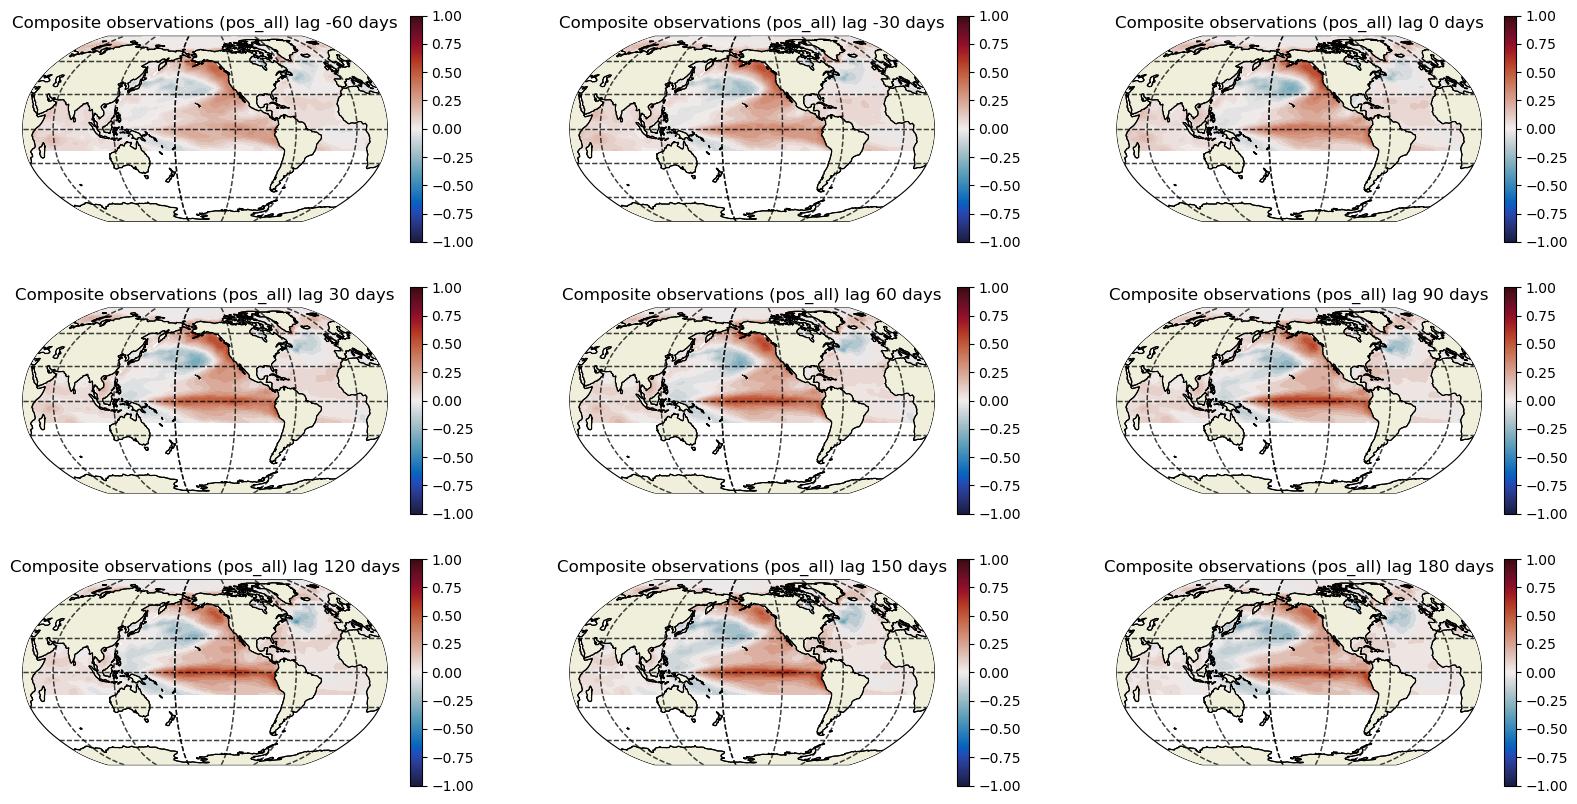

In [13]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive_all)")
plt.show()

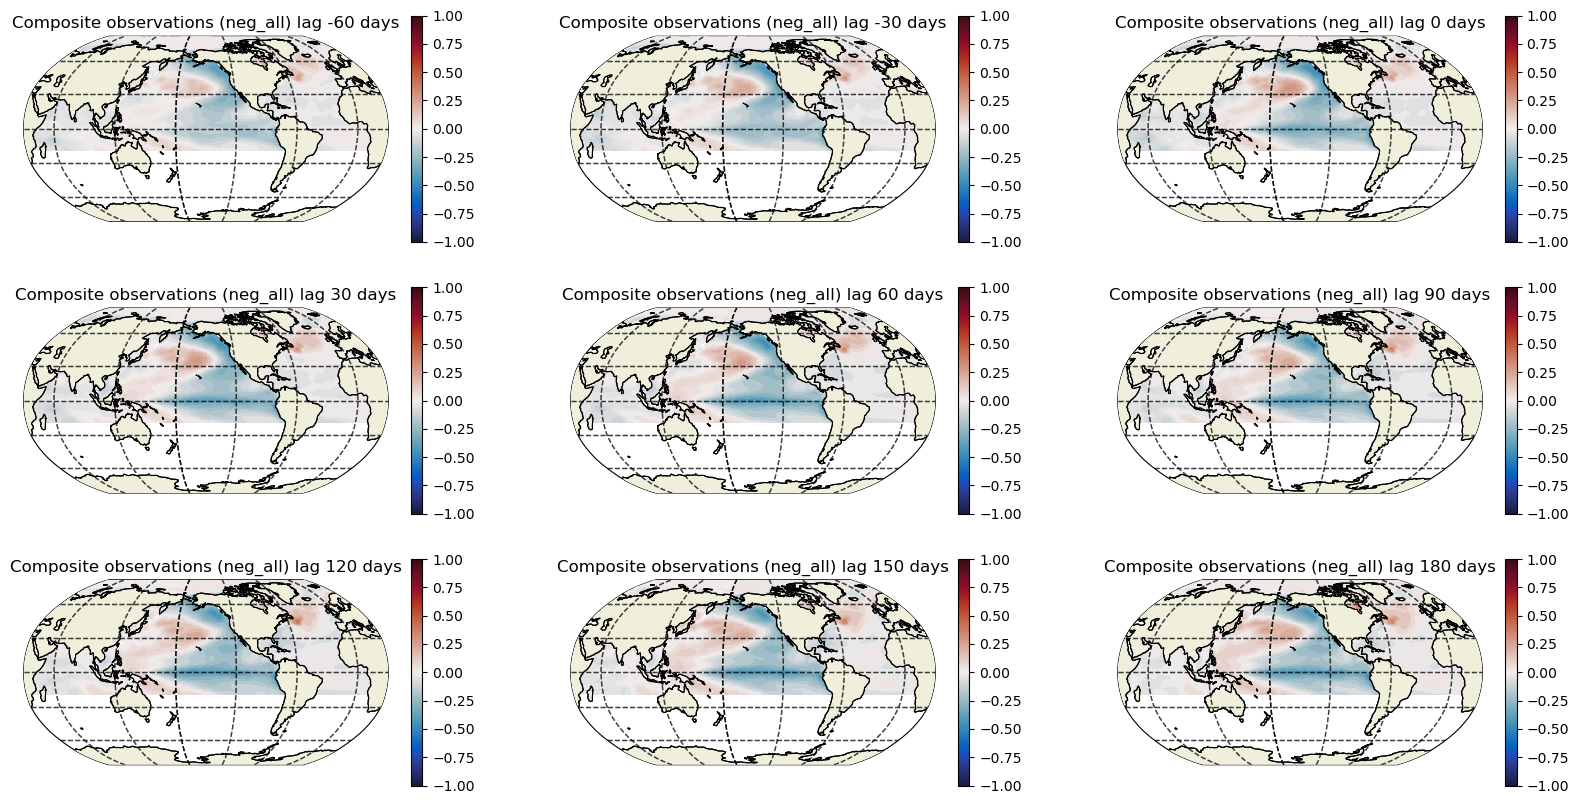

In [14]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative_all)")
plt.show()

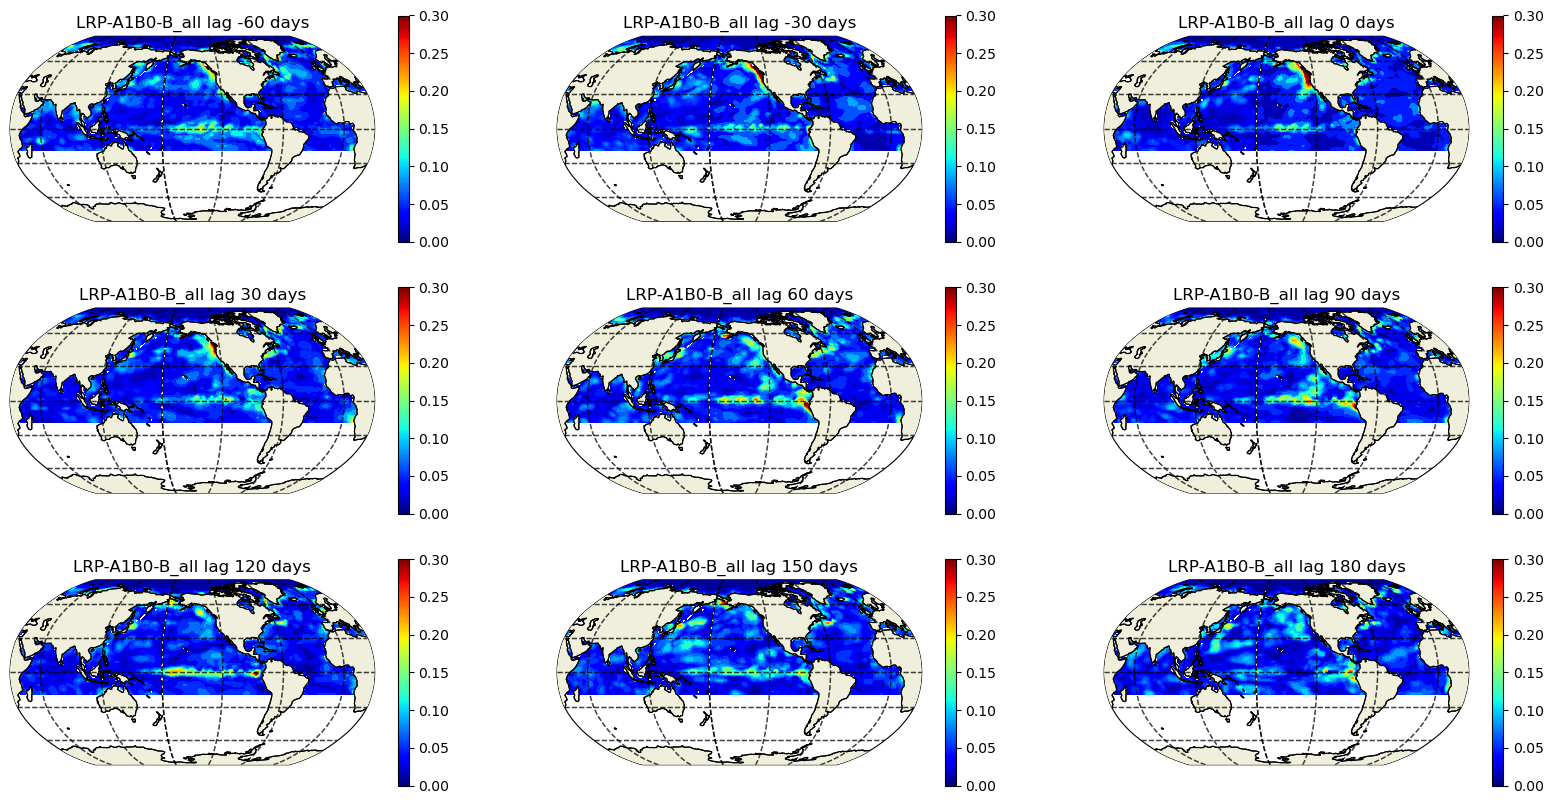

In [15]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_pos_all'].copy()
        # Max for each sample is already 1 so no real need to divide by max
        field = field / np.nanmax(field, axis = (1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
        field = np.nanmean(field, axis=0)
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True, 
                                      cmap = 'jet', 
                                      cmin = 0.0, 
                                      cmax = 0.3,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1

    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for pos QoI' w/o neg relevances")
    plt.show()

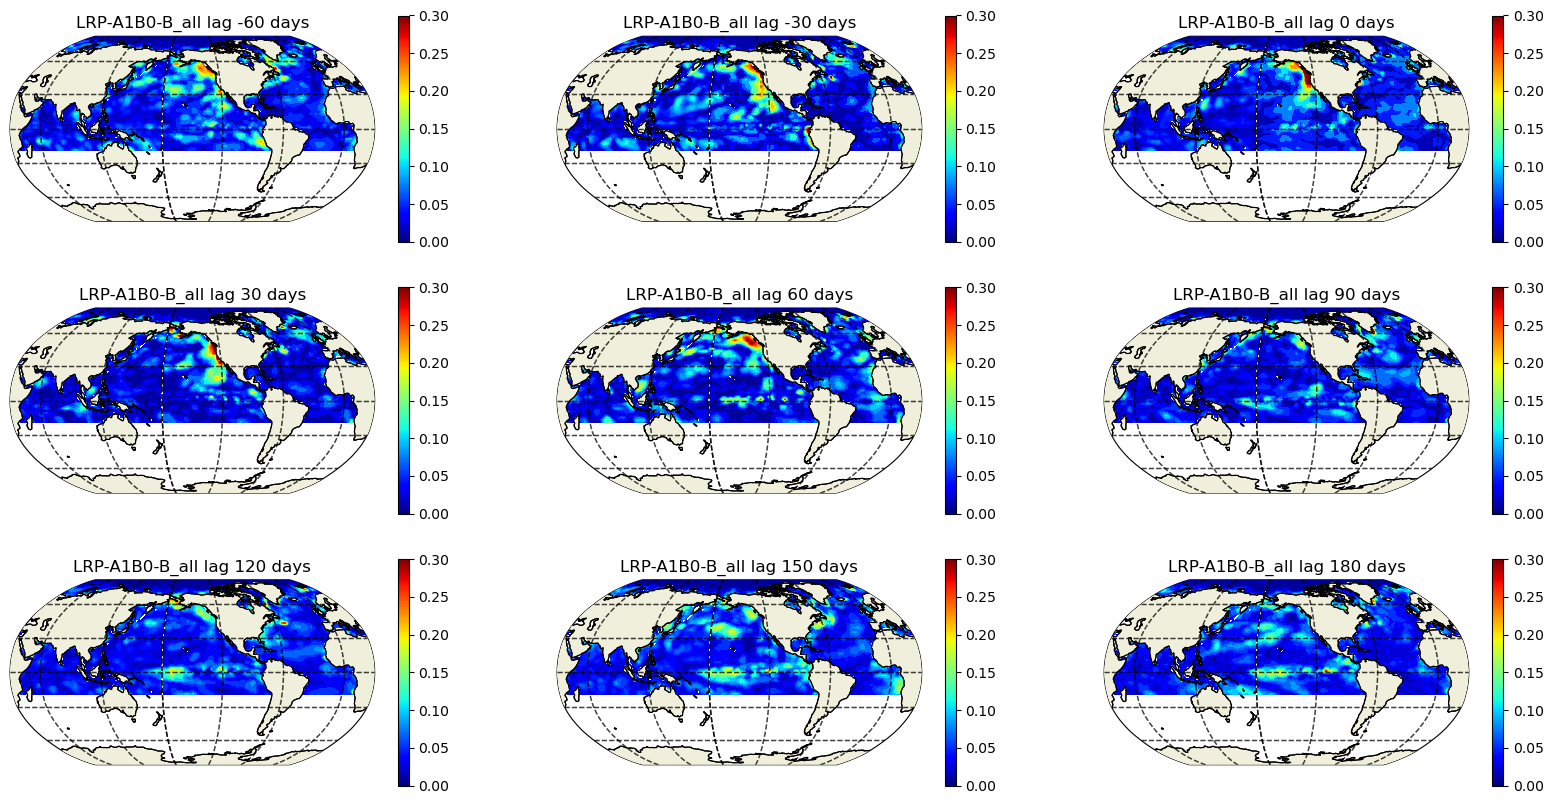

In [16]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_neg_all'].copy()
        # Max for each sample is already 1 so no real need to divide by max
        field = field / np.nanmax(field, axis = (1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
        field = np.nanmean(field, axis=0)
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True,
                                      cmap = 'jet', 
                                      cmin = 0.0, 
                                      cmax = 0.3,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for neg QoI' w/o neg relevances")
    plt.show()